# Notebook for getting an overview of COVID-numbers in the late autumn 2022 to Winter 2022/2023

In [4]:
# %matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
# import seaborn as sns


import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use('RasmusStyle.mplstyle')

from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

from datetime import date

import sys
sys.path.insert(1,'../scripts/') # Add path to scripts, to allow importing PandemiXFunctions
import PandemiXFunctions as pf


saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

# # Define running mean functions
# def rnMean(data,meanWidth):
#     return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')
# def rnTime(t,meanWidth):
#     return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]

saveFigures is set to: True
Done loading packages


In [127]:
# Define paths
rootdir_data = os.getcwd() +"/../DanskeData/" 

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"

path_figs = os.getcwd() +"/../Figures/" 
path_figs = path_figs + 'Overblik/'

# Load data

In [6]:
latestsubdir = list(os.walk(path_data))[0][1][-1]
latestdir = path_data + latestsubdir

dfCase = pd.read_csv(latestdir+'/Test_pos_over_time.csv',delimiter = ';',dtype=str)
dfCase = dfCase.iloc[:-2]
dfCase['NewPositive'] = pd.to_numeric(dfCase['NewPositive'].astype(str).apply(lambda x: x.replace('.','')))
dfCase['Tested'] = pd.to_numeric(dfCase['Tested'].astype(str).apply(lambda x: x.replace('.','')))
dfCase['PosPct'] = pd.to_numeric(dfCase['PosPct'].astype(str).apply(lambda x: x.replace(',','.')))
dfCase['Date'] =  pd.to_datetime(dfCase.Date,format='%Y-%m-%d')
testDates = dfCase['Date']

dfAdm = pd.read_csv(latestdir+'/Newly_admitted_over_time.csv',delimiter = ';',dtype=str)
dfAdm['Dato'] = pd.to_datetime(dfAdm['Dato'])
dfAdm['Total'] = pd.to_numeric(dfAdm['Total'])
dfAdm.tail()


dfDea = pd.read_csv(latestdir+'/Deaths_over_time.csv',delimiter = ';',dtype=str)
dfDea = dfDea.iloc[:-1,:]
dfDea['Dato'] = pd.to_datetime(dfDea['Dato'])
dfDea['Antal_døde'] = pd.to_numeric(dfDea['Antal_døde'])
dfDea.tail()

dfCase.tail()

,Date,NewPositive,NotPrevPos,PosPct,PrevPos,Tested,Tested_kumulativ
986,2022-10-09,1168,5.207,22.4,102,5309,65.470.774
987,2022-10-10,1633,10.550,15.5,164,10714,65.481.488
988,2022-10-11,1474,9.876,14.9,113,9989,65.491.477
989,2022-10-12,1411,8.989,15.7,137,9126,65.500.603
990,2022-10-13,1001,6.848,14.6,98,6946,65.507.549


## Reinfections data

In [64]:
latestsubdir = list(os.walk(path_dash))[0][1][-1]
latestdir = path_dash + latestsubdir 

dfReinfFile = pd.read_csv(latestdir+'/Regionalt_DB/24_reinfektioner_daglig_region.csv',encoding='latin1',delimiter = ';')
dfReinfFile['Prøvedato'] = pd.to_datetime(dfReinfFile['Prøvedato'])
# groupdf = df.groupby(['Prøvedato').sum()
# df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
# df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller bekræftet tilfælde)'] != '1.Reinfektion'].groupby('Prøvedato').sum()
df_reinf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] == '1.Reinfektion'].groupby('Prøvedato').sum()
df_inf = dfReinfFile[dfReinfFile['Type af tilfælde (reinfektion eller første infektion)'] != '1.Reinfektion'].groupby('Prøvedato').sum()

## Noegletal files

In [17]:
# Load data from "noegletal"
# Until 2021-12-20, all dates were included in one file. Since then, additional data was added, and the file only contains the most recent numbers

latestsubdirs_dash = list(os.walk(path_dash))[0][1]
# latestsubdirs_dash == 'SSI_dashboard_2021-12-17'
lastFullFileIndex = np.where([x == 'SSI_dashboard_2021-12-17' for x in latestsubdirs_dash])[0][0]
latestdir_dash = path_dash + latestsubdirs_dash[lastFullFileIndex]

dfKey = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')

dfKeysArray = []
for k in range(lastFullFileIndex+1,len(latestsubdirs_dash)):
    
    latestdir_dash = path_dash + latestsubdirs_dash[k]
    curdf = pd.read_csv(latestdir_dash+'\\Kommunalt_DB\\01_noegletal.csv',encoding='latin1',delimiter=';')
    dfKeysArray.append(curdf)
    

dfKey['IndberetningDato'] = pd.to_datetime(dfKey['IndberetningDato'])

# print(dfKey.columns)
# dfKey.tail()

In [18]:
# Make arrays to plot
keyDates = dfKey.IndberetningDato
keyDatesShift = keyDates + np.timedelta64(365,'D')
keyCase = dfKey['Antal nye bekræftede tilfælde']
keyNewAdm = dfKey['Antal nye indlæggelser']
keyAdm = dfKey['Antal indlagte i dag med COVID']
keyAdmInt = dfKey['Antal indlagt i dag på intensiv']
keyAdmResp = dfKey['Antal indlagt i dag og i respirator']
keyDeath = dfKey['Antal nye døde']
keyTest = dfKey['Antal prøver siden sidst']

## Add the new data

# 2021-12-20 still used old names
dateToAdd = np.datetime64(pd.to_datetime(dfKeysArray[0].IndberetningDato.values[0]))
keyDates = np.append(keyDates,dateToAdd)
keyCase = np.append(keyCase,dfKeysArray[0]['Antal nye bekræftede tilfælde'][0])
keyNewAdm = np.append(keyNewAdm,dfKeysArray[0]['Antal nye indlæggelser'][0])
keyAdm = np.append(keyAdm,dfKeysArray[0]['Antal indlagte i dag med COVID'][0])
keyAdmInt = np.append(keyAdmInt,dfKeysArray[0]['Antal indlagt i dag på intensiv'][0])
keyAdmResp = np.append(keyAdmResp,dfKeysArray[0]['Antal indlagt i dag og i respirator'][0])
keyDeath = np.append(keyDeath,dfKeysArray[0]['Antal nye døde'][0])
keyTest = np.append(keyTest,dfKeysArray[0]['Antal prøver siden sidst'][0])

# Make an array for missing reinfection data
keyCaseReInf = keyCase * np.nan 

# After which the new names are used
for k in range(1,len(dfKeysArray)):
    thisDate = dfKeysArray[k].Dato[0]
    # thisCase = dfKeysArray[k]['Bekræftede tilfælde siden sidste opdatering'][0]
    thisCase = dfKeysArray[k]['Bekræftede tilfælde i alt siden sidste opdatering'][0]
    thisNewAdm = dfKeysArray[k]['Nyindlæggelser siden sidste opdatering'][0]
    thisDeath = dfKeysArray[k]['Dødsfald siden sidste opdatering'][0]
    thisAdm = dfKeysArray[k]['Indlæggelser i dag'][0]
    thisAdmInt = dfKeysArray[k]['Indlæggelser i dag (intensiv)'][0]
    thisAdmResp = dfKeysArray[k]['Indlæggelser i dag (respirator)'][0]
    thisTest = dfKeysArray[k]['PRC-tests siden sidste opdatering'][0]
    # # print(dfKeysArray[k])
    # print(thisDate)
    # print(thisAdm)
    # print(thisAdmInt)
    
    thisCaseReInf = dfKeysArray[k]['Reinfektioner siden sidste opdatering'][0]

    keyDates = np.append(keyDates,np.datetime64(thisDate))
    keyCase = np.append(keyCase,thisCase)
    keyNewAdm = np.append(keyNewAdm,thisNewAdm)
    keyAdm = np.append(keyAdm,thisAdm)
    keyAdmInt = np.append(keyAdmInt,thisAdmInt)
    keyAdmResp = np.append(keyAdmResp,thisAdmResp)
    keyDeath = np.append(keyDeath,thisDeath)
    keyTest = np.append(keyTest,thisTest)

    keyCaseReInf = np.append(keyCaseReInf,thisCaseReInf)


keyDates = keyDates.astype('datetime64[D]')
keyDatesShift = keyDates + np.timedelta64(365,'D')

# Collect everything in a single dataframe
dfKeyFull = pd.DataFrame()
dfKeyFull['Date'] = keyDates
dfKeyFull['Cases_New'] = keyCase
dfKeyFull['Cases_Reinfection'] = keyCaseReInf
dfKeyFull['New_Admissions'] = keyNewAdm
dfKeyFull['Hospitalizations'] = keyAdm
dfKeyFull['ICU'] = keyAdmInt
dfKeyFull['Respirator'] = keyAdmResp
dfKeyFull['Deaths'] = keyDeath
dfKeyFull['Tests'] = keyTest

In [30]:
dfKeyFull.tail(20)

,Date,Cases_New,Cases_Reinfection,New_Admissions,Hospitalizations,ICU,Respirator,Deaths,Tests
810,2022-09-19,1798,405.0,132,302,10,2,11,13746
811,2022-09-20,962,237.0,75,316,7,1,2,7040
812,2022-09-21,1069,249.0,51,314,6,1,10,7957
813,2022-09-22,859,219.0,78,308,6,1,5,6409
814,2022-09-23,1306,323.0,67,316,9,1,5,9644
815,2022-09-26,2572,606.0,202,376,4,1,13,16483
816,2022-09-27,1476,391.0,78,384,6,2,4,9189
817,2022-09-28,1613,414.0,94,386,8,3,14,10667
818,2022-09-29,1348,355.0,44,387,8,3,8,9651
819,2022-09-30,1241,330.0,111,396,11,4,9,9373


# Make dfKeyFull, but with weekly numbers

In [203]:
dfMain = dfKeyFull.copy()

# cur 
# # curDate = dfMain. 

for i,r in dfMain.iterrows():
    # print(r.Date)
    curDate = r.Date 
    curDateRange = [curDate + np.timedelta64(x,'D') for x in np.arange(-3,4)]
    
    # r.iloc[1:] = dfMain[dfMain.Date.isin(curDateRange)].sum()/7
    dfMain.iloc[i,1:] =dfMain[dfMain.Date.isin(curDateRange)].sum()/7

curDateRange

C:\Users\rakrpe\AppData\Local\Temp\ipykernel_7228\2173442620.py:12: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  dfMain.iloc[i,1:] =dfMain[dfMain.Date.isin(curDateRange)].sum()/7


[Timestamp('2022-10-11 00:00:00'),
 Timestamp('2022-10-12 00:00:00'),
 Timestamp('2022-10-13 00:00:00'),
 Timestamp('2022-10-14 00:00:00'),
 Timestamp('2022-10-15 00:00:00'),
 Timestamp('2022-10-16 00:00:00'),
 Timestamp('2022-10-17 00:00:00')]

In [204]:
# dfMain[dfMain.Date.isin(curDateRange)].mean()
# dfMain[dfMain.Date.isin(curDateRange)].sum()/7
# r.iloc[1:] = dfMain[dfMain.Date.isin(curDateRange)].sum()/7

display(dfKeyFull.tail())
display(dfMain.tail())

,Date,Cases_New,Cases_Reinfection,New_Admissions,Hospitalizations,ICU,Respirator,Deaths,Tests
825,2022-10-10,3496,884.0,249,456,18,3,20,19694
826,2022-10-11,1670,442.0,131,496,18,3,10,10525
827,2022-10-12,1402,399.0,131,504,18,1,7,10231
828,2022-10-13,1519,385.0,105,507,14,1,7,9607
829,2022-10-14,1152,337.0,97,502,14,2,8,8792


,Date,Cases_New,Cases_Reinfection,New_Admissions,Hospitalizations,ICU,Respirator,Deaths,Tests
825,2022-10-10,1308.815023,341.287854,98.802351,314.462992,10.907301,1.300808,7.232054,8085.839102
826,2022-10-11,1007.402146,272.041122,80.400336,331.923285,10.701043,1.185830,5.604579,6748.691300
827,2022-10-12,912.745310,247.761282,73.171812,308.483754,9.658335,0.926662,4.976662,6209.218629
828,2022-10-13,842.851783,226.155751,64.910643,280.552861,8.466668,0.916186,4.687614,5634.678433
829,2022-10-14,559.285606,154.708308,45.068970,203.279986,6.118007,0.718383,3.324122,3912.084052


# Make some general overviews

# Cases

In [111]:
curTotCases = df_inf.infected+df_reinf.infected
recentMax = curTotCases.values[-100:].max()

yMax = (np.ceil(recentMax/1000)+1.5)*1000

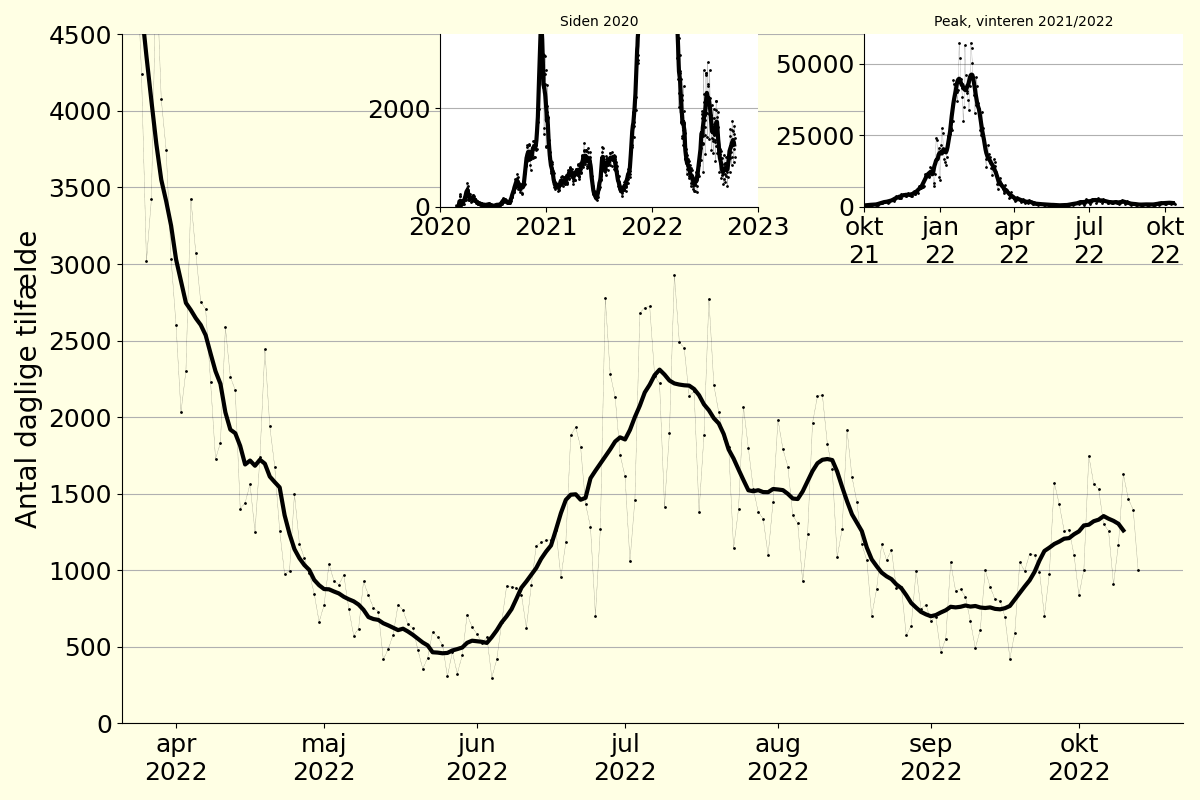

In [129]:
fig,ax = plt.subplots()

# ax.plot(dfKeyFull.Date,dfKeyFull.Cases_New,'k.:',lw=0.5)
# ax.plot(dfMain.Date,dfMain.Cases_New,'b')
# mw = 7
# ax.plot(pf.rnTime(dfKeyFull.Date,mw),pf.rnMean(dfKeyFull.Cases_New,mw),'k')

ax.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
mw = 7
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')

ax.set_ylim(bottom=0)

yMax = (np.ceil(recentMax/1000)+0.5)*1000
ax.set_ylim(top=yMax)


leftDate = np.datetime64('today') - np.timedelta64(30*7,'D')
rightDate = np.datetime64('today') + np.timedelta64(5,'D')

ax.set_xlim(left=leftDate)
ax.set_xlim(right=rightDate)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_ylabel('Antal daglige tilfælde')


if saveFigures:
    fig.savefig(path_figs+'Cases')

axin1 = ax.inset_axes([0.7, 0.75, 0.3, 0.25])
axin2 = ax.inset_axes([0.3, 0.75, 0.3, 0.25])

axin1.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
axin1.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')
axin2.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
axin2.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')

leftDatePeak = np.datetime64('2021-10-01')
rightDatePeak = rightDate

axin1.set_ylim(bottom=0)
axin1.set_xlim(left=leftDatePeak,right=rightDatePeak)


axin2.set_xlim(right=rightDate)
axin2.set_ylim(bottom=0,top=yMax)


axin1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%y'))
axin2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axin1.set_xticks(np.arange(np.datetime64('2021-10'),np.datetime64('2022-12'),np.timedelta64(3,'M')))
axin2.set_xticks(np.arange(np.datetime64('2020'),np.datetime64('2024')))

yMax = (np.ceil(recentMax/1000)+1.5)*1000
ax.set_ylim(top=yMax)


axin1.set_title('Peak, vinteren 2021/2022',fontsize=10)
axin2.set_title('Siden 2020',fontsize=10)

axin1.set_facecolor('w')
axin2.set_facecolor('w')

if saveFigures:
    fig.savefig(path_figs+'CasesMedInset')

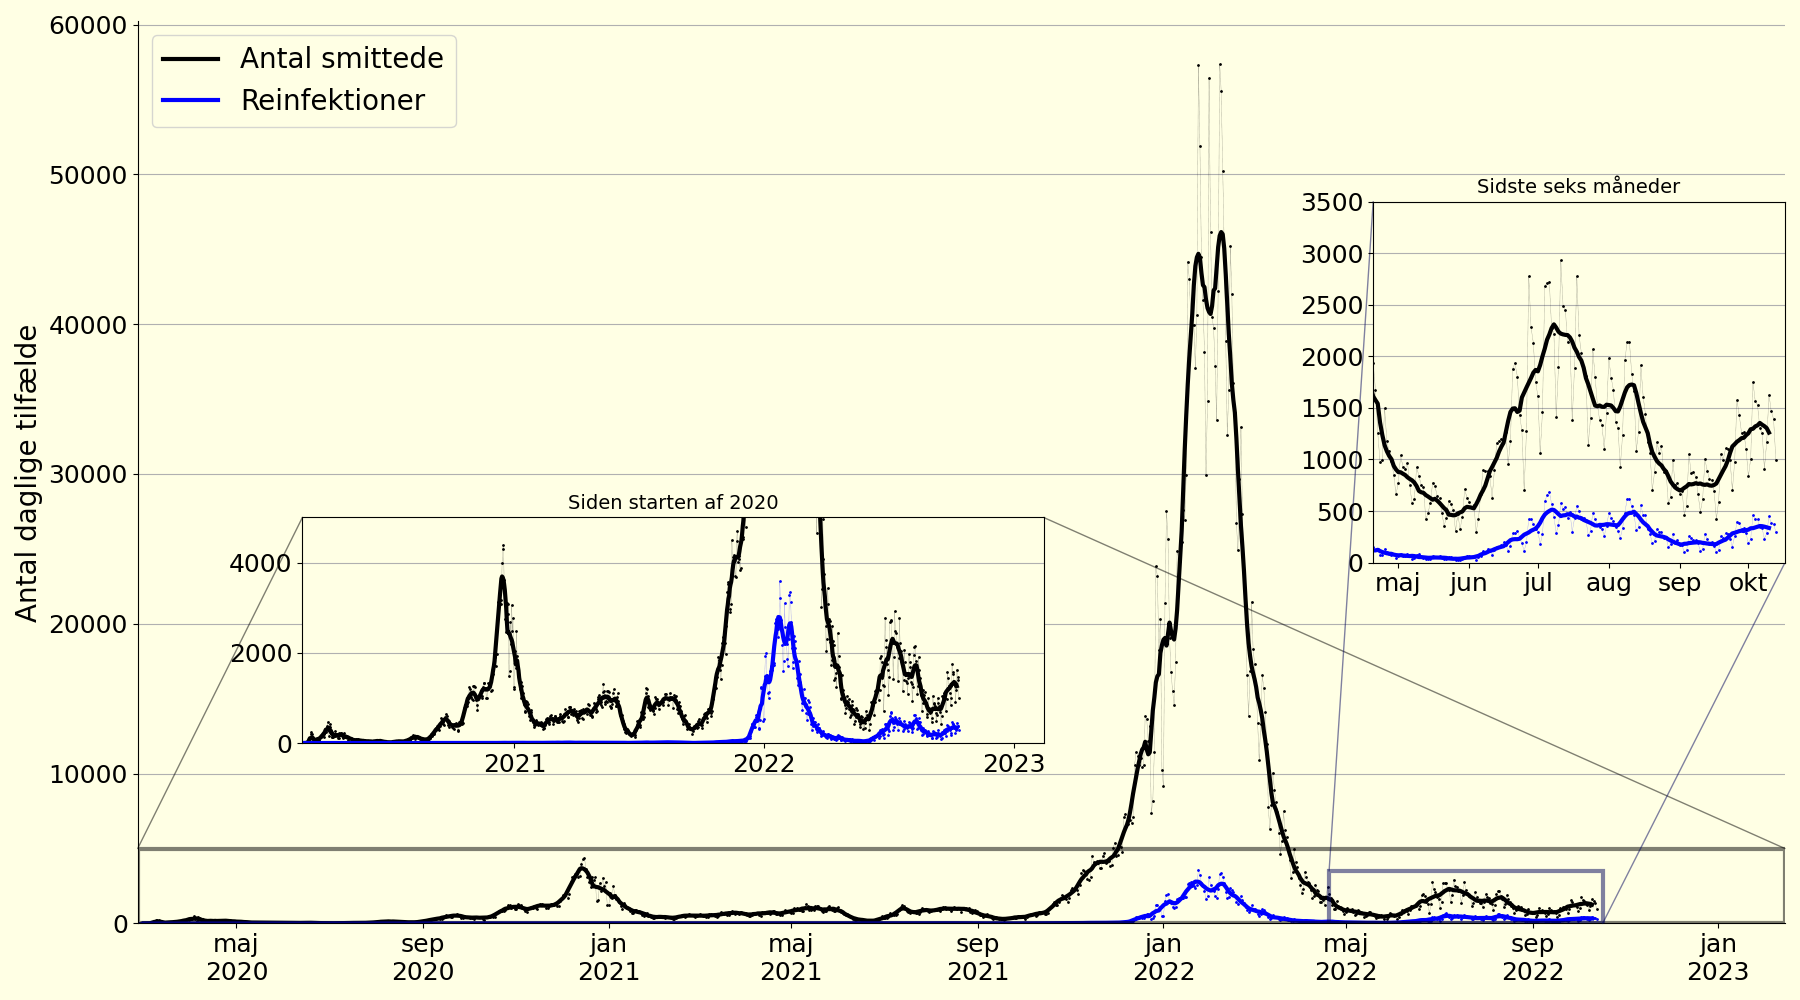

In [185]:
# Omvendt inset: Hel graf, men med udklip

fig,ax = plt.subplots(figsize=(18,10))


mw = 7

ax.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k',label='Antal smittede')
ax.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b',label='Reinfektioner')

ax.legend(loc='upper left',fontsize=20)

ax.set_ylim(bottom=0)


leftDate = df_inf.index.values[0]
rightDate = np.datetime64('today') + np.timedelta64(30*4,'D')

ax.set_xlim([leftDate,rightDate])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# First inset: Whole periods, zoom y
axins = ax.inset_axes([0.1, 0.2, 0.45, 0.25])

axins.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
axins.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')
axins.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
axins.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b')
axins.spines['top'].set_visible(True)
axins.spines['right'].set_visible(True)
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axins.set_xticks(np.arange(np.datetime64('2020'),np.datetime64('2024')))

axins.set_ylim(bottom=0)
axins.set_ylim(top=5000)
axins.set_xlim([leftDate,rightDate])

ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=3)

# Second inset: Recent period
axins2 = ax.inset_axes([0.75, 0.4, 0.25, 0.4])

axins2.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
axins2.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')
axins2.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
axins2.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b')
axins2.spines['top'].set_visible(True)
axins2.spines['right'].set_visible(True)
axins2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axins2.set_xticks(np.arange(np.datetime64('2021-10'),np.datetime64('2023-06'),np.timedelta64(1,'M')))


axins2.set_ylim(bottom=0)
axins2.set_ylim(top=3500)
leftDate2 = np.datetime64('today') - np.timedelta64(30*6,'D')
rightDate2 = np.datetime64('today')

axins2.set_xlim([leftDate2,rightDate2])
ax.indicate_inset_zoom(axins2, edgecolor="xkcd:dark blue",linewidth=3)



axins.set_title('Siden starten af 2020',fontsize=14)
axins2.set_title('Sidste seks måneder',fontsize=14)

ax.set_ylabel('Antal daglige tilfælde')

fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'CasesFullInset_Reinf')


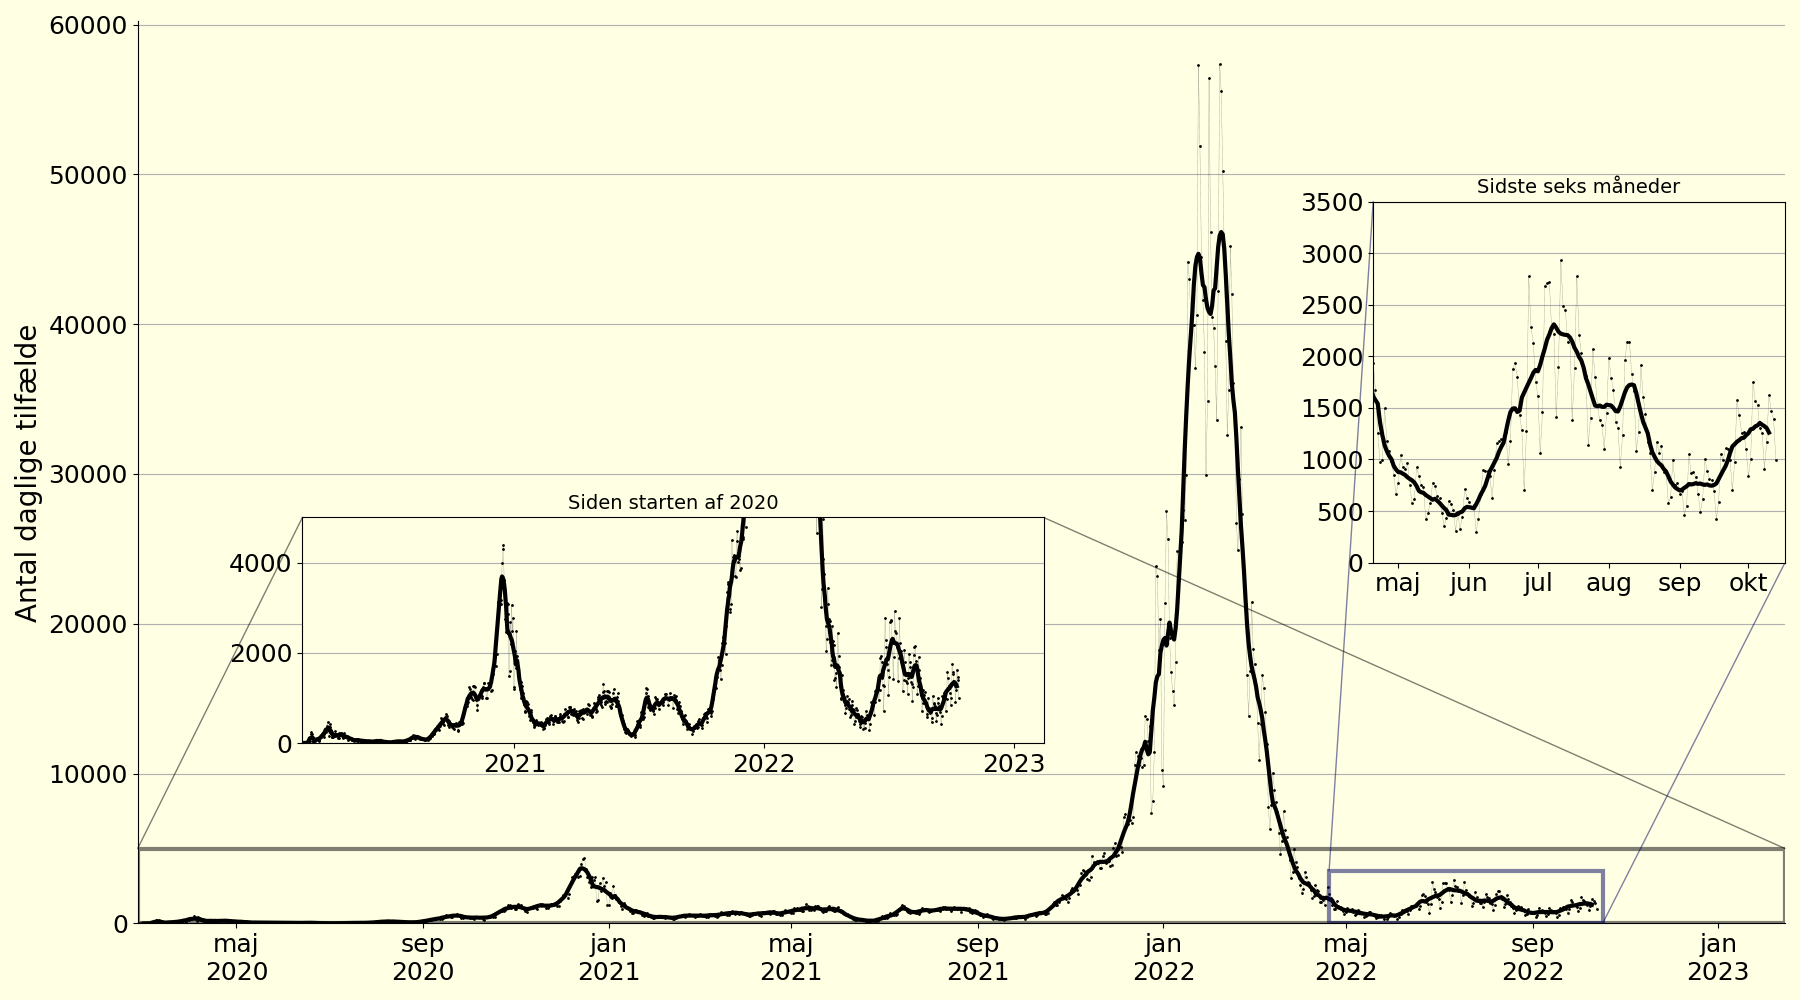

In [182]:
# Omvendt inset: Hel graf, men med udklip

fig,ax = plt.subplots(figsize=(18,10))


mw = 7

ax.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')
# ax.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
# ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b')


ax.set_ylim(bottom=0)


leftDate = df_inf.index.values[0]
rightDate = np.datetime64('today') + np.timedelta64(30*4,'D')

ax.set_xlim([leftDate,rightDate])

ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

# First inset: Whole periods, zoom y
axins = ax.inset_axes([0.1, 0.2, 0.45, 0.25])

axins.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
axins.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')
# axins.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
# axins.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b')
axins.spines['top'].set_visible(True)
axins.spines['right'].set_visible(True)
axins.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axins.set_xticks(np.arange(np.datetime64('2020'),np.datetime64('2024')))

axins.set_ylim(bottom=0)
axins.set_ylim(top=5000)
axins.set_xlim([leftDate,rightDate])

ax.indicate_inset_zoom(axins, edgecolor="black",linewidth=3)

# Second inset: Recent period
axins2 = ax.inset_axes([0.75, 0.4, 0.25, 0.4])

axins2.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
axins2.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k')
# axins2.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
# axins2.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b')
axins2.spines['top'].set_visible(True)
axins2.spines['right'].set_visible(True)
axins2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
axins2.set_xticks(np.arange(np.datetime64('2021-10'),np.datetime64('2023-06'),np.timedelta64(1,'M')))


axins2.set_ylim(bottom=0)
axins2.set_ylim(top=3500)
leftDate2 = np.datetime64('today') - np.timedelta64(30*6,'D')
rightDate2 = np.datetime64('today')

axins2.set_xlim([leftDate2,rightDate2])
ax.indicate_inset_zoom(axins2, edgecolor="xkcd:dark blue",linewidth=3)



axins.set_title('Siden starten af 2020',fontsize=14)
axins2.set_title('Sidste seks måneder',fontsize=14)

ax.set_ylabel('Antal daglige tilfælde')

fig.tight_layout()

if saveFigures:
    fig.savefig(path_figs+'CasesFullInset')


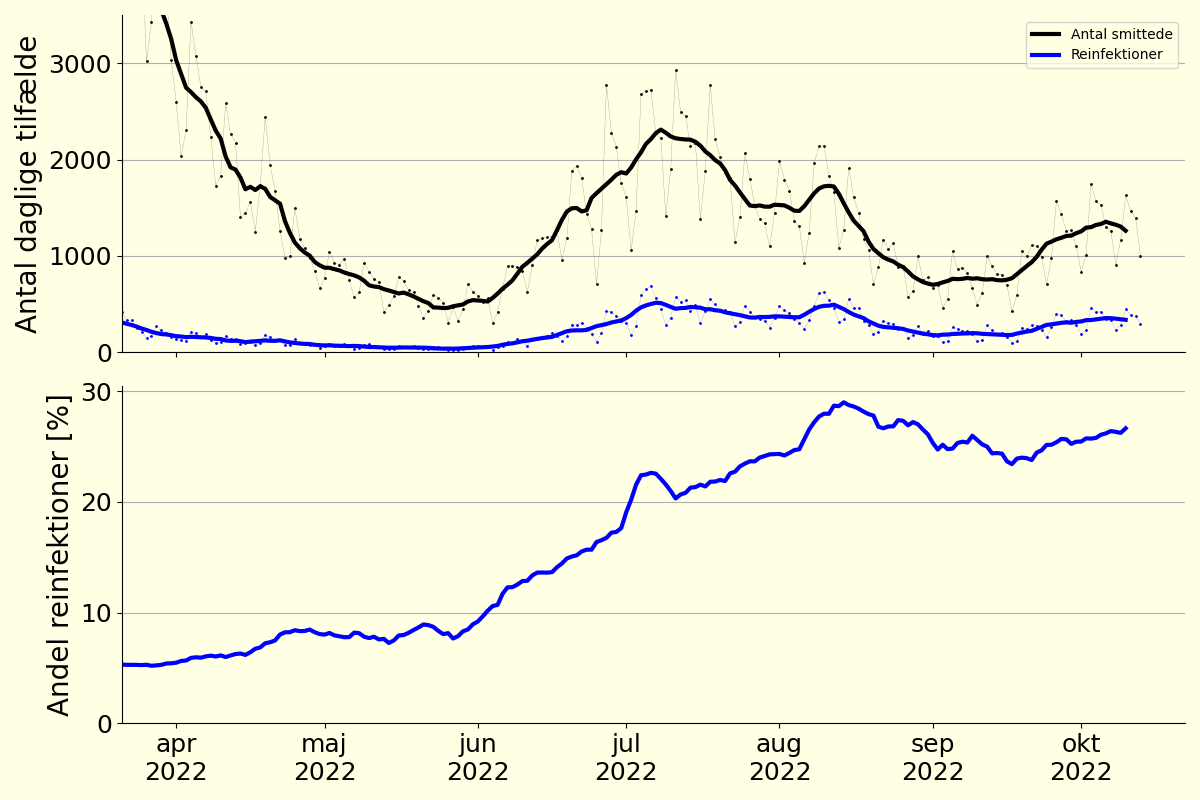

In [198]:
# Reinfektioner for sig

fig,(ax,ax2) = plt.subplots(2,1,sharex=True)

mw = 7

ax.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'k',label='Antal smittede')
ax.plot(df_inf.index,df_reinf.infected,'b.:',lw=0.25,ms=2)
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_reinf.infected,mw),'b',label='Reinfektioner')

ax2.plot(pf.rnTime(df_inf.index,mw),100 * pf.rnMean(df_reinf.infected,mw)/pf.rnMean(df_inf.infected+df_reinf.infected,mw),'b')

ax.legend()



yMax = (np.ceil(recentMax/1000)+0.5)*1000
ax.set_ylim(top=yMax)
ax.set_ylim(bottom=0)


leftDate = np.datetime64('today') - np.timedelta64(30*7,'D')
rightDate = np.datetime64('today') + np.timedelta64(5,'D')

ax.set_xlim(left=leftDate)
ax.set_xlim(right=rightDate)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_ylabel('Antal daglige tilfælde')
ax2.set_ylabel('Andel reinfektioner [%]')

ax2.set_ylim(bottom=0)

fig.tight_layout()
if saveFigures:
    fig.savefig(path_figs+'CasesReinfektioner')

# Indlæggelser

In [249]:
dfAdm.tail()
dfMain.tail()

,Date,Cases_New,Cases_Reinfection,New_Admissions,Hospitalizations,ICU,Respirator,Deaths,Tests
825,2022-10-10,1308.815023,341.287854,98.802351,314.462992,10.907301,1.300808,7.232054,8085.839102
826,2022-10-11,1007.402146,272.041122,80.400336,331.923285,10.701043,1.185830,5.604579,6748.691300
827,2022-10-12,912.745310,247.761282,73.171812,308.483754,9.658335,0.926662,4.976662,6209.218629
828,2022-10-13,842.851783,226.155751,64.910643,280.552861,8.466668,0.916186,4.687614,5634.678433
829,2022-10-14,559.285606,154.708308,45.068970,203.279986,6.118007,0.718383,3.324122,3912.084052


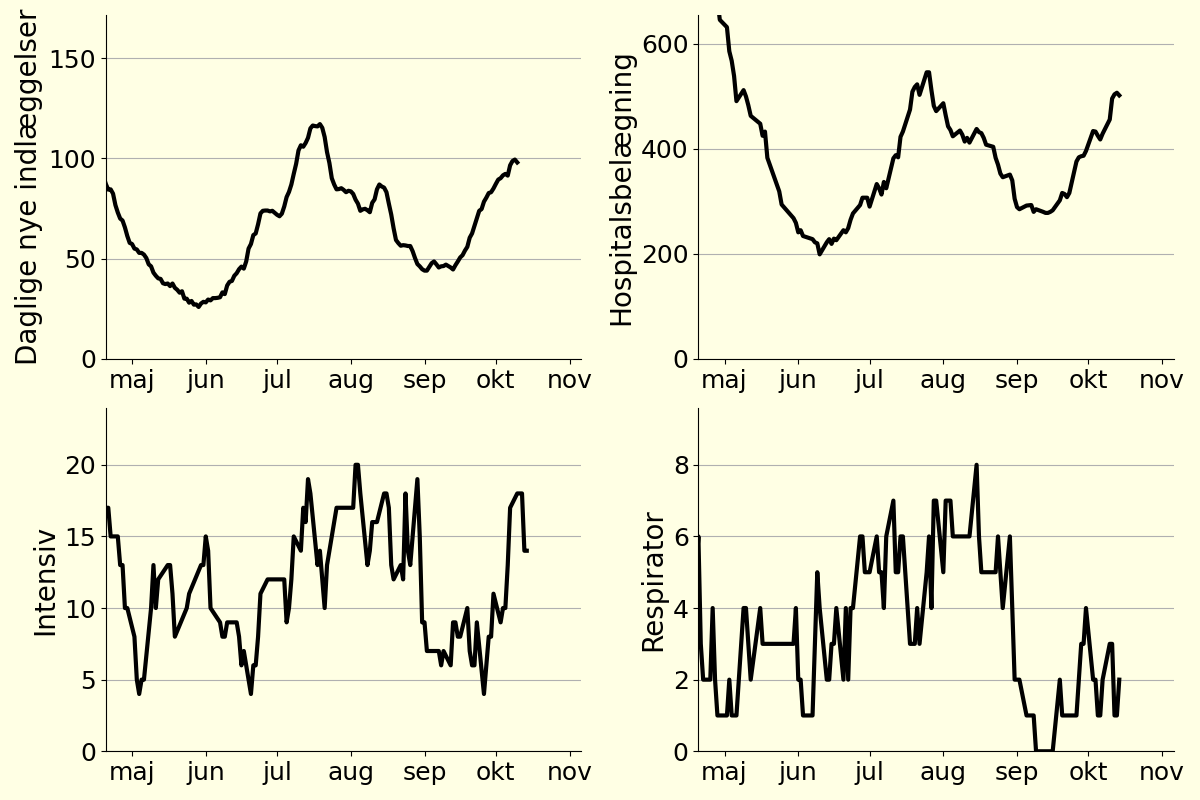

In [269]:
fig,(allAxes) = plt.subplots(2,2)

ax1 = allAxes.flatten()[0]
ax2 = allAxes.flatten()[1]
ax3 = allAxes.flatten()[2]
ax4 = allAxes.flatten()[3]

# ax.plot(dfMain.Date,dfMain.ICU)
# ax.plot(dfMain.Date,dfMain.Hospitalizations)
# ax.plot(dfKeyFull.Date,dfKeyFull.Hospitalizations)
# ax.plot(dfMain.Date,dfMain.New_Admissions)
# ax.plot(dfKeyFull.Date,dfKeyFull.New_Admissions)


ax1.plot(pf.rnTime(dfAdm.Dato,mw),pf.rnMean(dfAdm.Total,mw),'k')
ax2.plot(dfKeyFull.Date,dfKeyFull.Hospitalizations,'k')
ax3.plot(dfKeyFull.Date,dfKeyFull.ICU,'k')
ax4.plot(dfKeyFull.Date,dfKeyFull.Respirator,'k')


recentMax1 = np.max(dfAdm.Total[-60:])
recentMax2 = np.max(dfKeyFull.Hospitalizations[-60:])
recentMax3 = np.max(dfKeyFull.ICU[-60:])
recentMax4 = np.max(dfKeyFull.Respirator[-60:])

ax1.set_ylim(top=recentMax1*1.2)
ax2.set_ylim(top=recentMax2*1.2)
ax3.set_ylim(top=recentMax3*1.2)
ax4.set_ylim(top=recentMax4*1.2)

for ax in allAxes.flatten():

    leftDate = np.datetime64('today') - np.timedelta64(30*6,'D')
    rightDate = np.datetime64('today') + np.timedelta64(20,'D')

    ax.set_xlim([leftDate,rightDate])
    ax.set_ylim(bottom=0)
        
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

ax1.set_ylabel('Daglige nye indlæggelser')
ax2.set_ylabel('Hospitalsbelægning')
ax3.set_ylabel('Intensiv')
ax4.set_ylabel('Respirator')


fig.tight_layout()
if saveFigures:
    fig.savefig(path_figs+'Hospital')

# Dødsfald

In [229]:
np.sum(dfKeyFull.Deaths)
# np.sum(dfDea['Antal_døde'])
yMax

17

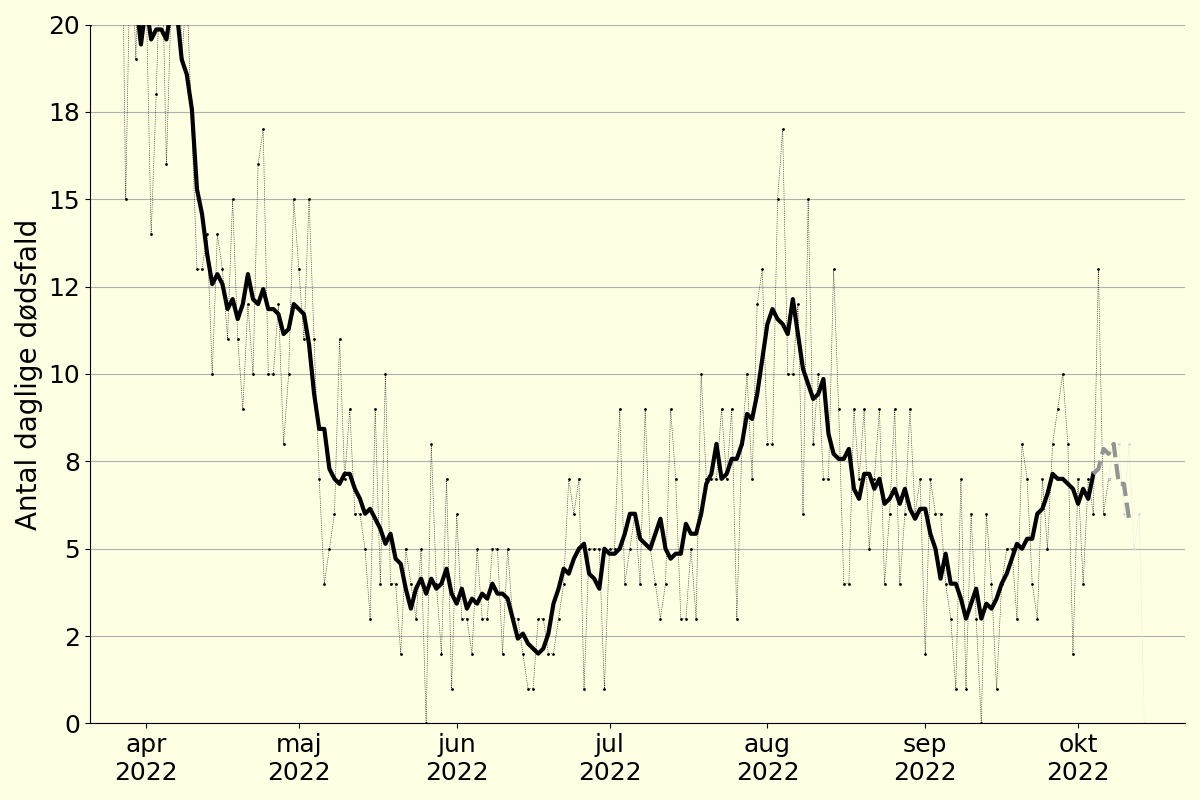

In [270]:
# display(dfDea.tail(20))
# display(dfKeyFull.tail(20))

fig,ax = plt.subplots()

mw = 7
# ax.plot(dfDea.Dato,dfDea['Antal_døde'],'k.:',ms=2,lw=0.5)
# ax.plot(pf.rnTime(dfDea.Dato,mw),pf.rnMean(dfDea['Antal_døde'],mw),'k')
ax.plot(dfDea.Dato[:-7],dfDea['Antal_døde'][:-7],'k.:',ms=2,lw=0.5)
ax.plot(pf.rnTime(dfDea.Dato,mw)[:-7],pf.rnMean(dfDea['Antal_døde'],mw)[:-7],'k')
ax.plot(dfDea.Dato[-8:],dfDea['Antal_døde'][-8:],'.:',ms=2,lw=0.5,color='xkcd:light grey')
ax.plot(pf.rnTime(dfDea.Dato,mw)[-8:],pf.rnMean(dfDea['Antal_døde'],mw)[-8:],'--',color='xkcd:grey')
# ax.plot(dfMain.Date,dfMain.Deaths,'.:')
# ax.plot(dfKeyFull.Date,dfKeyFull.Deaths,'o--')


recentMax = np.max(dfDea['Antal_døde'].values[-60:])



yMax = (np.ceil(recentMax/5)+1)*5
ax.set_ylim(top=yMax)
ax.set_ylim(bottom=0)


leftDate = np.datetime64('today') - np.timedelta64(30*7,'D')
rightDate = np.datetime64('today') + np.timedelta64(5,'D')

ax.set_xlim(left=leftDate)
ax.set_xlim(right=rightDate)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_ylabel('Antal daglige dødsfald')

from matplotlib.ticker import FormatStrFormatter
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))


fig.tight_layout()
if saveFigures:
    fig.savefig(path_figs+'Deaths')

# Tests

In [280]:
# dfCase

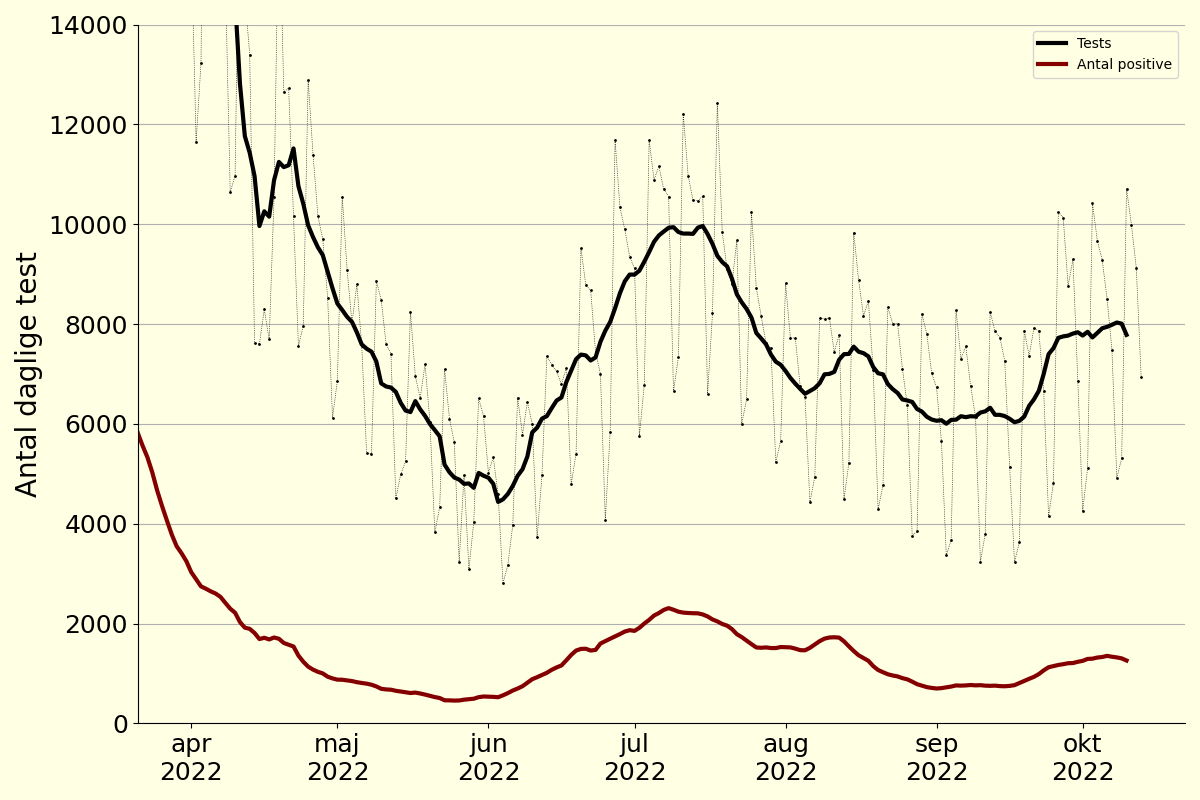

In [294]:
fig,ax = plt.subplots()

# ax.plot(dfMain.Date,dfMain.Tests)
# ax.plot(dfCase.Date,dfCase.Tested)
# ax.plot(df_inf.index,df_inf.infected+df_reinf.infected)

ax.plot(dfCase.Date,dfCase.Tested,'k.:',ms=2,lw=0.5)
ax.plot(pf.rnTime(dfCase.Date,mw),pf.rnMean(dfCase.Tested,mw),'k',label='Tests')





# ax.plot(df_inf.index,df_inf.infected+df_reinf.infected,'k.:',lw=0.25,ms=2)
ax.plot(pf.rnTime(df_inf.index,mw),pf.rnMean(df_inf.infected+df_reinf.infected,mw),'xkcd:dark red',label='Antal positive')


ax.legend()

recentMax = np.max(dfCase.Tested.values[-60:])



yMax = (np.ceil(recentMax/2000)+1)*2000
ax.set_ylim(top=yMax)
ax.set_ylim(bottom=0)


leftDate = np.datetime64('today') - np.timedelta64(30*7,'D')
rightDate = np.datetime64('today') + np.timedelta64(5,'D')

ax.set_xlim(left=leftDate)
ax.set_xlim(right=rightDate)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
ax.set_ylabel('Antal daglige test')

fig.tight_layout()
if saveFigures:
    fig.savefig(path_figs+'Tests')


In [283]:
dfCase.tail(20)

,Date,NewPositive,NotPrevPos,PosPct,PrevPos,Tested,Tested_kumulativ
971,2022-09-24,706,4.076,17.3,77,4153,65.355.675
972,2022-09-25,980,4.733,20.7,88,4821,65.360.496
973,2022-09-26,1582,10.117,15.6,128,10245,65.370.741
974,2022-09-27,1433,9.999,14.3,130,10129,65.380.870
975,2022-09-28,1264,8.650,14.6,117,8767,65.389.637
976,2022-09-29,1269,9.182,13.8,115,9297,65.398.934
977,2022-09-30,1102,6.746,16.3,115,6861,65.405.795
978,2022-10-01,840,4.182,20.1,80,4262,65.410.057
979,2022-10-02,1011,5.037,20.1,71,5108,65.415.165
980,2022-10-03,1751,10.291,17.0,133,10424,65.425.589
